<a href="https://colab.research.google.com/github/eridgd/ArtNet-WCT-TF2/blob/master/ArtNet_WCT_TF2_Colab_VGG_Normalised_2019_07_27_NN_Upsample_Full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Copyright © 2019 Evan Davis

In [0]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fast Universal Style Transfer with Feature Transforms

>[Fast Universal Style Transfer with Feature Transforms](#scrollTo=TR-DY5AK-P8d)

>>[Enable Train mode to re-train the Decoder](#scrollTo=paWNdIhJcDeE)

>>[Make sure we're using a Tesla T4](#scrollTo=9SW1GsQB4qKr)

>>[Install TensorFlow 2.0 Beta](#scrollTo=KlQK7Shab3Hp)

>>[Downloads](#scrollTo=oaCeVZPi2rri)

>>>[VGG19 Weights](#scrollTo=qgxot8pSW6Kj)

>>>[Get pre-trained Decoder weights (if not training decoder from scratch)](#scrollTo=l3kL4Lzw9rsH)

>>>[Content images from MS COCO 2017 Test Set](#scrollTo=m7Tc_4eq7RUr)

>>>[Sample style images](#scrollTo=DQSs2azsVUEf)

>>[Model Training args](#scrollTo=2cTJQYoyMQgI)

>>[Make sure we're in Eager mode](#scrollTo=YVgocVROm4ZE)

>>[Setup Utilities](#scrollTo=OfHpGO8c63jv)

>>>[Image utilities](#scrollTo=GXZ1lTrKdc8F)

>>>[torchfile.py](#scrollTo=fV0mqgc4W6Lf)

>>>[Define WCT / AdaIn / Style-Swap Feature Transforms](#scrollTo=_AzmblSe8wru)

>>>>[White-Color Transform (WCT)](#scrollTo=O73IkOTmv33N)

>>>>[Style-Swap](#scrollTo=ILasPqzKwU9S)

>>>>[Adaptive Instance Normalization (AdaIN)](#scrollTo=NROrTlKwwPLe)

>>[Prepare dataset with tf.data  (Skip if not re-training Decoder)](#scrollTo=sIZWm4IuUPFk)

>>>[Build a tf.data.Dataset](#scrollTo=sIZWm4IuUPFk)

>>[Define Model](#scrollTo=gqA-p5m_UPGO)

>>>[VGG19 from vgg_normalised.t7](#scrollTo=703BA4idiHV3)

>>>[Pyramid Fusion Conv layer to combine VGG features](#scrollTo=rDYVfUuPiQXu)

>>>[ArtNet Decoder](#scrollTo=SA5ZGUlUjLSx)

>>[Train Decoder](#scrollTo=wdiQ2pjnd0Na)

>>>[TensorBoard](#scrollTo=DcemRJIaXKHO)

>>>[Train Loop](#scrollTo=vByjoVf8XTSz)

>>[Stylize with full Autoencoder](#scrollTo=OYU_UuqIeQjZ)

>>>[Load trained decoder weights](#scrollTo=ZiO4LCCvea9D)

>>>[Define stylization procedure](#scrollTo=W9Mg-YUYlcBl)

>>>[Load random content & style images](#scrollTo=x8TPKsRhkaBZ)

>>>[Stylize test](#scrollTo=4xIvL-ZQmHPA)

>>[Webcam Demo](#scrollTo=9len-gzKr5hz)

>>>[Sullivan demo](#scrollTo=AFHUhPdpW6NJ)



## Enable Train mode to re-train the Decoder

A pre-trained decoder is already included, only set to True if re-training the Decoder.

In [0]:
TRAIN_MODE = False

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Make sure we're using a Tesla T4

In [0]:
!nvidia-smi

Mon Jul 29 21:41:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    30W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Install TensorFlow 2.0 Beta

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

## Downloads


### VGG19 Weights

In [0]:
!wget -c -O vgg_normalised.t7 "https://www.dropbox.com/s/kh8izr3fkvhitfn/vgg_normalised.t7?dl=1"

--2019-07-29 21:41:20--  https://www.dropbox.com/s/kh8izr3fkvhitfn/vgg_normalised.t7?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/kh8izr3fkvhitfn/vgg_normalised.t7 [following]
--2019-07-29 21:41:21--  https://www.dropbox.com/s/dl/kh8izr3fkvhitfn/vgg_normalised.t7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2b15671ab6222512324c7ffeca.dl.dropboxusercontent.com/cd/0/get/AlqqCVDoqi4_LmWIlGvXfrpLw39KdIqEWXI4BRyE9RnNpiJX1YC60uhDK1ZDFmxRGw8skZpcASRAhT5qZSI6ZAMTonn8PVjOwAmIB_fKzdp5fg/file?dl=1# [following]
--2019-07-29 21:41:21--  https://uc2b15671ab6222512324c7ffeca.dl.dropboxusercontent.com/cd/0/get/AlqqCVDoqi4_LmWIlGvXfrpLw39KdIqEWXI4BRyE9RnNpiJX1YC60uhDK1ZDFmxRGw8skZpcASRAhT5qZSI6ZAMTonn8PVjOwAmIB_fKzdp5fg/file?d

### Get pre-trained Decoder weights (if not training decoder from scratch)

In [0]:
if TRAIN_MODE is False:
  !wget -c -O decoder_weights.keras https://www.dropbox.com/s/lo6j0n923rr8gup/decoder_weights.keras?dl=1

--2019-07-29 21:41:23--  https://www.dropbox.com/s/lo6j0n923rr8gup/decoder_weights.keras?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/lo6j0n923rr8gup/decoder_weights.keras [following]
--2019-07-29 21:41:23--  https://www.dropbox.com/s/dl/lo6j0n923rr8gup/decoder_weights.keras
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca28c8a896fbe268907d9fa46ff.dl.dropboxusercontent.com/cd/0/get/Alr-letTkVIp4C5zey2UvxqnYy4rCGfY2QfJrqhg1SZ-SdMkO0T-8NYCfaUW2SD_DxXSIn8dR414LL3DkczBJsR-9xEoJitQ7escI-IkTXVaOjXdVNWc7R5WEXUU-46bvDM/file?dl=1# [following]
--2019-07-29 21:41:23--  https://uca28c8a896fbe268907d9fa46ff.dl.dropboxusercontent.com/cd/0/get/Alr-letTkVIp4C5zey2UvxqnYy4rCGfY2QfJrqhg1SZ-SdMkO0T-8NYCfaUW2SD_DxXSIn8dR414LL3DkczB

### Content images from MS COCO 2017 Test Set

MS COCO 2017 test set contains 40K that we'll use to train the autoencoder. Full dataset available at http://cocodataset.org/#download

In [0]:
%%time

if TRAIN_MODE:
  !wget -c http://images.cocodataset.org/zips/test2017.zip
    
  !unzip -q -u test2017

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [0]:
# %%time

# if TRAIN_MODE:
#    !wget -c http://images.cocodataset.org/zips/val2017.zip
    
#    !unzip -q -u val2017

### Sample style images

This is a random sample of the WikiArt dataset obtained from https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset

Also obtain the "Describable Textures Dataset" from https://www.robots.ox.ac.uk/~vgg/data/dtd/#citation

In [0]:
if TRAIN_MODE is False:
    !wget -c https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

    !tar xfz dtd-r1.0.1.tar.gz
    
    from pathlib import Path
    style_image_paths = [str(f) for f in Path('dtd').glob('**/*.jpg')]
    len(style_image_paths)

--2019-07-29 21:41:25--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
if TRAIN_MODE is False:
    !wget -c -O wikiart_samples.tar.gz https://www.dropbox.com/s/emq7zqzmjipnv49/wikiart_samples.tar.gz?dl=1

    !tar xfz wikiart_samples.tar.gz
    
    from pathlib import Path
    style_image_paths = [str(f) for f in Path('wikiart_samples').glob('**/*.jpg')]
    len(style_image_paths)

--2019-07-29 21:41:32--  https://www.dropbox.com/s/emq7zqzmjipnv49/wikiart_samples.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/emq7zqzmjipnv49/wikiart_samples.tar.gz [following]
--2019-07-29 21:41:33--  https://www.dropbox.com/s/dl/emq7zqzmjipnv49/wikiart_samples.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7560301862b9e7e98c090ec882.dl.dropboxusercontent.com/cd/0/get/AlqiSXEGFe4BQE3JcfVKkNiyYUMSl7nW17JIH3Qy7goyGxM4bvGRhIZXnor1d9UWrgbtWUxhJmwgkdX2l_nnT9a6iuLxG4yDpvDjHZUc3lJQghVw2Rc9dKd5Feh89ZhOFQw/file?dl=1# [following]
--2019-07-29 21:41:33--  https://uc7560301862b9e7e98c090ec882.dl.dropboxusercontent.com/cd/0/get/AlqiSXEGFe4BQE3JcfVKkNiyYUMSl7nW17JIH3Qy7goyGxM4bvGRhIZXnor1d9UWrgbtWUxhJmwgkdX2l

In [0]:
!ls

1920px-Tsunami_by_hokusai_19th_century.jpg  sample_data
decoder_weights.keras			    starry_night_full.jpg
drive					    vgg_normalised.t7
dtd					    wikiart_samples
dtd-r1.0.1.tar.gz			    wikiart_samples.tar.gz
gilbert.jpg


## Model Training args

In [0]:
import argparse

parser = argparse.ArgumentParser()

### Directories
parser.add_argument('--save-path', type=str,
                    dest='save_path', help='Decoder weights save path',
                    default='drive/My Drive/artnet_decoder_full_nnupsample_40kunlabeled_tv0.keras',  # Save to Drive
                    required=False)
parser.add_argument('--log-path', type=str,
                    dest='log_path', help='Logging dir path', default='artnet_decoder_full_nnupsample')
parser.add_argument('--train-path', type=str, 
                   default='test2017/',
                    #  default='val2017/',
                    dest='train_path', help='Content images folder')
parser.add_argument('--vgg-path', type=str,
                    dest='vgg_path', help='Path to vgg_normalised.t7', 
                    default='vgg_normalised.t7')

### Loss weights
parser.add_argument('--feature-weight', type=float,
                    dest='feature_weight', help='Feature loss weight',
                    default=1)
parser.add_argument('--pixel-weight', type=float,
                    dest='pixel_weight', help='Pixel reconstruction loss weight',
                    default=1)
parser.add_argument('--tv-weight', type=float,
                    dest='tv_weight', help='Total variation loss weight',
                    default=1e-6)

### Train opts
parser.add_argument('--img-size', type=int,
                    dest='img_size', help='Image resize size',
                    default=512)
parser.add_argument('--learning-rate', type=float,
                    dest='learning_rate', help='Learning rate',
                    default=1e-4)
parser.add_argument('--train-steps', type=int,
                    dest='train_steps', help='Max # of training iterations',
                    default=40000)
parser.add_argument('--batch-size', type=int,
                    dest='batch_size', help='Batch size',
                    default=4)
parser.add_argument('--sample-iter', type=int,
                    dest='sample_iter', help='Frequency to sample autoencoder outputs',
                    default=100)
parser.add_argument('--save-iter', type=int,
                    dest='save_iter', help='Model save frequency',
                    default=1000)
parser.add_argument('--seed', type=bool,
                    dest='seed', help='Random seed',
                    default=0)                    

args = parser.parse_known_args()[0]

## Make sure we're in Eager mode

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

assert tf.executing_eagerly()

## Setup Utilities

### Image utilities

In [0]:
def resize_image_keep_aspect(image, lo_dim):
    shape = tf.shape(image)
    width, height = shape[0], shape[1]
    min_ = tf.minimum(width, height)
    ratio = tf.cast(min_, tf.float32) / tf.constant(lo_dim, dtype=tf.float32)
    new_width = tf.cast(tf.cast(width, tf.float32) / ratio, tf.int32)
    new_height = tf.cast(tf.cast(height, tf.float32) / ratio, tf.int32)
    return tf.image.resize(image, [new_width, new_height])

In [0]:
def preprocess_image(image, size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = resize_image_keep_aspect(image, size)
    image = tf.image.random_crop(image, (size,size,3))
    image /= 255.0  # normalize to [0,1] range
    return image

In [0]:
def load_and_preprocess_image(path, size=args.img_size):
    image = tf.io.read_file(path)
    return preprocess_image(image, size=size)

In [0]:
import PIL
import IPython.display as ipydisplay

def plot_image(image):
    if len(image.shape) == 4:
        image = image[0]
    image *= 255
    ipydisplay.display(PIL.Image.fromarray((image).numpy().astype('uint8')))

In [0]:
def deconv_output_length(input_length, filter_size, padding, stride):
  """Determines output length of a transposed convolution given input length.
  Arguments:
      input_length: integer.
      filter_size: integer.
      padding: one of "same", "valid", "full".
      stride: integer.
  Returns:
      The output length (integer).
  From: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/layers/utils.py#L159
  """
  if input_length is None:
    return None
  input_length *= stride
  if padding == 'valid':
    input_length += max(filter_size - stride, 0)
  elif padding == 'full':
    input_length -= (stride + filter_size - 2)
  return input_length

### torchfile.py

This is used to load a "normalised" version of VGG19 from a Torch .t7 file. Slightly modified from the original at https://github.com/bshillingford/python-torchfile

In [0]:
"""
Copyright (c) 2016, Brendan Shillingford
All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""

"""
Modified version of torchfile that is py3 and Windows compatible
Fixes provided by @xdaimon https://github.com/bshillingford/python-torchfile/pull/13
----------------------------------------------------------------------
Mostly direct port of the Lua and C serialization implementation to
Python, depending only on `struct`, `array`, and numpy.

Supported types:
 * `nil` to Python `None`
 * numbers to Python floats, or by default a heuristic changes them to ints or
   longs if they are integral
 * booleans
 * strings: read as byte strings (Python 3) or normal strings (Python 2), like
   lua strings which don't support unicode, and that can contain null chars
 * tables converted to a special dict (*); if they are list-like (i.e. have
   numeric keys from 1 through n) they become a python list by default
 * Torch classes: supports Tensors and Storages, and most classes such as
   modules. Trivially extensible much like the Torch serialization code.
   Trivial torch classes like most `nn.Module` subclasses become
   `TorchObject`s. The `type_handlers` dict contains the mapping from class
   names to reading functions.
 * functions: loaded into the `LuaFunction` `namedtuple`,
   which simply wraps the raw serialized data, i.e. upvalues and code.
   These are mostly useless, but exist so you can deserialize anything.

(*) Since Lua allows you to index a table with a table but Python does not, we
    replace dicts with a subclass that is hashable, and change its
    equality comparison behaviour to compare by reference.
    See `hashable_uniq_dict`.

Currently, the implementation assumes the system-dependent binary Torch
format, but minor refactoring can give support for the ascii format as well.
"""
import struct
from array import array
import numpy as np
import sys
from collections import namedtuple


TYPE_NIL = 0
TYPE_NUMBER = 1
TYPE_STRING = 2
TYPE_TABLE = 3
TYPE_TORCH = 4
TYPE_BOOLEAN = 5
TYPE_FUNCTION = 6
TYPE_RECUR_FUNCTION = 8
LEGACY_TYPE_RECUR_FUNCTION = 7

LuaFunction = namedtuple('LuaFunction',
                         ['size', 'dumped', 'upvalues'])

class mycontainer():
    def __init__(self, val):
        self.val = val
    def __hash__(self):
        return id(self.val)
    def __eq__(self, other):
        return id(self.val) == id(other.val)
    def __ne__(self, other):
        return id(self.val) != id(other.val)

class hashable_uniq_dict(dict):
    """
    Subclass of dict with equality and hashing semantics changed:
    equality and hashing is purely by reference/instance, to match
    the behaviour of lua tables.

    Supports lua-style dot indexing.

    This way, dicts can be keys of other dicts.
    """

    def __iter__(self):
        return iter(self.keys())

    def __getitem__(self, k):
        for _k,v in self.items():
            if str(_k) == str(k):
                return v

    def __setitem__(self, k, v):
        dict.__setitem__(self, mycontainer(k), v)

    def items(self):
        return [(k.val, v) for k,v in dict.items(self)]

    def keys(self):
        return [k.val for k in dict.keys(self)]

    def values(self):
        return [v for v in dict.values(self)]

    def __hash__(self):
        return id(self)

    def __eq__(self, other):
        return id(self) == id(other)

    def _disabled_binop(self, other):
        raise TypeError(
            'hashable_uniq_dict does not support these comparisons')
    __cmp__ = __ne__ = __le__ = __gt__ = __lt__ = _disabled_binop

class TorchObject(object):
    """
    Simple torch object, used by `add_trivial_class_reader`.
    Supports both forms of lua-style indexing, i.e. getattr and getitem.
    Use the `torch_typename` method to get the object's torch class name.

    Equality is by reference, as usual for lua (and the default for Python
    objects).
    """

    def __init__(self, typename, obj=None, version_number=0):
        self._typename = typename
        self._obj = obj
        self._version_number = version_number

    def __getattr__(self, k):
        if k in self._obj.keys():
            return self._obj[k]
        if isinstance(k, (str, bytes)):
            return self._obj[k.encode('utf8')]
    
    def __getitem__(self, k):
        if k in self._obj.keys():
            return self._obj[k]
        if isinstance(k, (str, bytes)):
            return self._obj[k.encode('utf8')]

    def torch_typename(self):
        return self._typename

    def __repr__(self):
        return "TorchObject(%s, %s)" % (self._typename, repr(self._obj))

    def __str__(self):
        return repr(self)

    def __dir__(self):
        keys = self._obj.keys()
        keys.append('torch_typename')
        return keys


type_handlers = {}


def register_handler(typename):
    def do_register(handler):
        type_handlers[typename] = handler
    return do_register


def add_tensor_reader(typename, dtype):
    def read_tensor_generic(reader, version):
        # https://github.com/torch/torch7/blob/1e86025/generic/Tensor.c#L1249
        ndim = reader.read_int()

        size = reader.read_long_array(ndim)
        stride = reader.read_long_array(ndim)
        storage_offset = reader.read_long() - 1  # 0-indexing
        # read storage:
        storage = reader.read_obj()

        if storage is None or ndim == 0 or len(size) == 0 or len(stride) == 0:
            # empty torch tensor
            return np.empty((0), dtype=dtype)

        # convert stride to numpy style (i.e. in bytes)
        stride = [storage.dtype.itemsize * x for x in stride]

        # create numpy array that indexes into the storage:
        return np.lib.stride_tricks.as_strided(
            storage[storage_offset:],
            shape=size,
            strides=stride)
    type_handlers[typename] = read_tensor_generic
add_tensor_reader(b'torch.ByteTensor', dtype=np.uint8)
add_tensor_reader(b'torch.CharTensor', dtype=np.int8)
add_tensor_reader(b'torch.ShortTensor', dtype=np.int16)
add_tensor_reader(b'torch.IntTensor', dtype=np.int32)
add_tensor_reader(b'torch.LongTensor', dtype=np.int64)
add_tensor_reader(b'torch.FloatTensor', dtype=np.float32)
add_tensor_reader(b'torch.DoubleTensor', dtype=np.float64)
add_tensor_reader(b'torch.CudaTensor', dtype=np.float32)
add_tensor_reader(b'torch.CudaByteTensor', dtype=np.uint8)
add_tensor_reader(b'torch.CudaCharTensor', dtype=np.int8)
add_tensor_reader(b'torch.CudaShortTensor', dtype=np.int16)
add_tensor_reader(b'torch.CudaIntTensor', dtype=np.int32)
add_tensor_reader(b'torch.CudaDoubleTensor', dtype=np.float64)


def add_storage_reader(typename, dtype):
    def read_storage(reader, version):
        # https://github.com/torch/torch7/blob/1e86025/generic/Storage.c#L237
        size = reader.read_long()
        return np.fromfile(reader.f, dtype=dtype, count=size)
    type_handlers[typename] = read_storage
add_storage_reader(b'torch.ByteStorage', dtype=np.uint8)
add_storage_reader(b'torch.CharStorage', dtype=np.int8)
add_storage_reader(b'torch.ShortStorage', dtype=np.int16)
add_storage_reader(b'torch.IntStorage', dtype=np.int32)
add_storage_reader(b'torch.LongStorage', dtype=np.int64)
add_storage_reader(b'torch.FloatStorage', dtype=np.float32)
add_storage_reader(b'torch.DoubleStorage', dtype=np.float64)
add_storage_reader(b'torch.CudaStorage', dtype=np.float32)
add_storage_reader(b'torch.CudaByteStorage', dtype=np.uint8)
add_storage_reader(b'torch.CudaCharStorage', dtype=np.int8)
add_storage_reader(b'torch.CudaShortStorage', dtype=np.int16)
add_storage_reader(b'torch.CudaIntStorage', dtype=np.int32)
add_storage_reader(b'torch.CudaDoubleStorage', dtype=np.float64)


def add_notimpl_reader(typename):
    def read_notimpl(reader, version):
        raise NotImplementedError('Reader not implemented for: ' + typename)
    type_handlers[typename] = read_notimpl
add_notimpl_reader(b'torch.HalfTensor')
add_notimpl_reader(b'torch.HalfStorage')
add_notimpl_reader(b'torch.CudaHalfTensor')
add_notimpl_reader(b'torch.CudaHalfStorage')


@register_handler(b'tds.Vec')
def tds_Vec_reader(reader, version):
    size = reader.read_int()
    obj = []
    _ = reader.read_obj()
    for i in range(size):
        e = reader.read_obj()
        obj.append(e)
    return obj


@register_handler(b'tds.Hash')
def tds_Hash_reader(reader, version):
    size = reader.read_int()
    obj = hashable_uniq_dict()
    _ = reader.read_obj()
    for i in range(size):
        k = reader.read_obj()
        v = reader.read_obj()
        obj[k] = v
    return obj


class T7ReaderException(Exception):
    pass


class T7Reader:

    def __init__(self,
                 fileobj,
                 use_list_heuristic=True,
                 use_int_heuristic=True,
                 utf8_decode_strings=False,
                 force_deserialize_classes=None,
                 force_8bytes_long=False):
        """
        Params:
        * `fileobj`: file object to read from, must be an actual file object
                    as it will be read by `array`, `struct`, and `numpy`. Since
                    it is only read sequentially, certain objects like pipes or
                    `sys.stdin` should work as well (untested).
        * `use_list_heuristic`: automatically turn tables with only consecutive
                                positive integral indices into lists
                                (default True)
        * `use_int_heuristic`: cast all whole floats into ints (default True)
        * `utf8_decode_strings`: decode all strings as UTF8. By default they
                                remain as byte strings. Version strings always
                                are byte strings, but this setting affects
                                class names. (default False)
        * `force_deserialize_classes`: deprecated.
        """
        self.f = fileobj
        self.objects = {}  # read objects so far

        if force_deserialize_classes is not None:
            raise DeprecationWarning(
                'force_deserialize_classes is now always '
                'forced to be true, so no longer required')
        self.use_list_heuristic = use_list_heuristic
        self.use_int_heuristic = use_int_heuristic
        self.utf8_decode_strings = utf8_decode_strings
        self.force_8bytes_long = force_8bytes_long

    def _read(self, fmt):
        sz = struct.calcsize(fmt)
        return struct.unpack(fmt, self.f.read(sz))

    def read_boolean(self):
        return self.read_int() == 1

    def read_int(self):
        return self._read('i')[0]

    def read_long(self):
        if self.force_8bytes_long:
            return self._read('q')[0]
        else:
            return self._read('l')[0]

    def read_long_array(self, n):
        if self.force_8bytes_long:
            lst = []
            for i in range(n):
                lst.append(self.read_long())
            return lst
        else:
            arr = array('l')
            arr.fromfile(self.f, n)
            return arr.tolist()

    def read_float(self):
        return self._read('f')[0]

    def read_double(self):
        return self._read('d')[0]

    def read_string(self, disable_utf8=False):
        size = self.read_int()
        s = self.f.read(size)
        if disable_utf8 or not self.utf8_decode_strings:
            return s
        return s.decode('utf8')

    def read_obj(self):
        typeidx = self.read_int()

        if typeidx == TYPE_NIL:
            return None

        elif typeidx == TYPE_NUMBER:
            x = self.read_double()
            # Extra checking for integral numbers:
            if self.use_int_heuristic and x.is_integer():
                return int(x)
            return x

        elif typeidx == TYPE_BOOLEAN:
            return self.read_boolean()

        elif typeidx == TYPE_STRING:
            return self.read_string()

        elif (typeidx == TYPE_TABLE or typeidx == TYPE_TORCH or
                typeidx == TYPE_FUNCTION or typeidx == TYPE_RECUR_FUNCTION or
                typeidx == LEGACY_TYPE_RECUR_FUNCTION):
            # read the object reference index
            index = self.read_int()

            # check it is loaded already
            if index in self.objects:
                return self.objects[index]

            # otherwise read it
            if (typeidx == TYPE_FUNCTION or typeidx == TYPE_RECUR_FUNCTION or
                    typeidx == LEGACY_TYPE_RECUR_FUNCTION):
                size = self.read_int()
                dumped = self.f.read(size)
                upvalues = self.read_obj()
                obj = LuaFunction(size, dumped, upvalues)
                self.objects[index] = obj
                return obj

            elif typeidx == TYPE_TORCH:
                version = self.read_string(disable_utf8=True)
                if version.startswith(b'V '):
                    version_number = int(float(version.partition(b' ')[2]))
                    class_name = self.read_string(disable_utf8=True)
                else:
                    class_name = version
                    # created before existence of versioning
                    version_number = 0
                if class_name in type_handlers:
                    # TODO: can custom readers ever be self-referential?
                    self.objects[index] = None  # FIXME: if self-referential
                    obj = type_handlers[class_name](self, version)
                    self.objects[index] = obj
                else:
                    # This must be performed in two steps to allow objects
                    # to be a property of themselves.
                    obj = TorchObject(
                        class_name, version_number=version_number)
                    self.objects[index] = obj
                    # After self.objects is populated, it's safe to read in
                    # case self-referential
                    obj._obj = self.read_obj()
                return obj

            else:  # it is a table: returns a custom dict or a list
                size = self.read_int()
                # custom hashable dict, so that it can be a key, see above
                obj = hashable_uniq_dict()
                # For checking if keys are consecutive and positive ints;
                # if so, returns a list with indices converted to 0-indices.
                key_sum = 0
                keys_natural = True
                # bugfix: obj must be registered before reading keys and vals
                self.objects[index] = obj

                for _ in range(size):
                    k = self.read_obj()
                    v = self.read_obj()
                    obj[k] = v

                    if self.use_list_heuristic:
                        if not isinstance(k, int) or k <= 0:
                            keys_natural = False
                        elif isinstance(k, int):
                            key_sum += k

                if self.use_list_heuristic:
                    # n(n+1)/2 = sum <=> consecutive and natural numbers
                    n = len(obj)
                    if keys_natural and n * (n + 1) == 2 * key_sum:
                        lst = []
                        for i in range(len(obj)):
                            elem = obj[i + 1]
                            # In case it is self-referential. This is not
                            # needed in lua torch since the tables are never
                            # modified as they are here.
                            if elem == obj:
                                elem = lst
                            lst.append(elem)
                        self.objects[index] = obj = lst

                return obj

        else:
            raise T7ReaderException(
                "unknown object type / typeidx: {}".format(typeidx))


def torchfile_load(filename, **kwargs):
    """
    Loads the given t7 file using default settings; kwargs are forwarded
    to `T7Reader`.
    """
    with open(filename, 'rb') as f:
        reader = T7Reader(f, **kwargs)
        return reader.read_obj()


### Define WCT / AdaIn / Style-Swap Feature Transforms

#### White-Color Transform (WCT)

In [0]:
### Whiten-Color Transform ops ###

def wct_tf(content, style, alpha, eps=1e-9):
    '''TensorFlow version of Whiten-Color Transform
       Assume that content/style encodings have shape 1xHxWxC

       See p.4 of the Universal Style Transfer paper for corresponding equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''
    # Remove batch dim and reorder to CxHxW
    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(tf.shape(content_t))
    Cs, Hs, Ws = tf.unstack(tf.shape(style_t))

    # CxHxW -> CxH*W
    content_flat = tf.reshape(content_t, (Cc, Hc*Wc))
    style_flat = tf.reshape(style_t, (Cs, Hs*Ws))

    # Content covariance
    mc = tf.reduce_mean(content_flat, axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = fc @ tf.transpose(fc) / tf.cast((Hc*Wc - 1), tf.float32) + tf.eye(Cc)*eps

    # Style covariance
    ms = tf.reduce_mean(style_flat, axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = fs @ tf.transpose(fs) / tf.cast((Hs*Ws - 1), tf.float32) + tf.eye(Cs)*eps

    # tf.linalg.svd is slower on GPU, see https://github.com/tensorflow/tensorflow/issues/13603
    with tf.device('/cpu:0'):  
        Sc, Uc, _ = tf.linalg.svd(fcfc)
        Ss, Us, _ = tf.linalg.svd(fsfs)

    ## Uncomment to perform SVD for content/style with np in one call
    ## This is slower than CPU tf.linalg.svd but won't segfault for ill-conditioned matrices
    # @jit
    # def np_svd(content, style):
    #     '''tf.py_func helper to run SVD with NumPy for content/style cov tensors'''
    #     Uc, Sc, _ = np.linalg.svd(content)
    #     Us, Ss, _ = np.linalg.svd(style)
    #     return Uc, Sc, Us, Ss
    # Uc, Sc, Us, Ss = tf.py_func(np_svd, [fcfc, fsfs], [tf.float32, tf.float32, tf.float32, tf.float32])

    # Filter small singular values
    k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.int32))
    k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.int32))

    # Whiten content feature
    Dc = tf.linalg.diag(tf.pow(Sc[:k_c], -0.5))
    fc_hat  = Uc[:,:k_c] @ Dc @ tf.transpose(Uc[:,:k_c]) @ fc

    # Color content with style
    Ds = tf.linalg.diag(tf.pow(Ss[:k_s], 0.5))
    fcs_hat = Us[:,:k_s] @ Ds @ tf.transpose(Us[:,:k_s]) @ fc_hat

    # Re-center with mean of style
    fcs_hat = fcs_hat + ms

    # Blend whiten-colored feature with original content feature
    blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)

    # CxH*W -> CxHxW
    blended = tf.reshape(blended, (Cc,Hc,Wc))
    # CxHxW -> 1xHxWxC
    blended = tf.expand_dims(tf.transpose(blended, (1,2,0)), 0)

    return blended


def wct_np(content, style, alpha=0.6, eps=1e-5):
    '''Perform Whiten-Color Transform on feature maps using numpy
       See p.4 of the Universal Style Transfer paper for equations:
       https://arxiv.org/pdf/1705.08086.pdf
    '''    
    # 1xHxWxC -> CxHxW
    content_t = np.transpose(np.squeeze(content), (2, 0, 1))
    style_t = np.transpose(np.squeeze(style), (2, 0, 1))

    # CxHxW -> CxH*W
    content_flat = content_t.reshape(-1, content_t.shape[1]*content_t.shape[2])
    style_flat = style_t.reshape(-1, style_t.shape[1]*style_t.shape[2])

    mc = content_flat.mean(axis=1, keepdims=True)
    fc = content_flat - mc

    fcfc = np.dot(fc, fc.T) / (content_t.shape[1]*content_t.shape[2] - 1)
    
    Ec, wc, _ = np.linalg.svd(fcfc)

    k_c = (wc > 1e-5).sum()

    Dc = np.diag((wc[:k_c]+eps)**-0.5)

    fc_hat = Ec[:,:k_c].dot(Dc).dot(Ec[:,:k_c].T).dot(fc)

    ms = style_flat.mean(axis=1, keepdims=True)
    fs = style_flat - ms

    fsfs = np.dot(fs, fs.T) / (style_t.shape[1]*style_t.shape[2] - 1)

    Es, ws, _ = np.linalg.svd(fsfs)

    k_s = (ws > 1e-5).sum()
    
    Ds = np.sqrt(np.diag(ws[:k_s]+eps))

    fcs_hat = Es[:,:k_s].dot(Ds).dot(Es[:,:k_s].T).dot(fc_hat)

    fcs_hat = fcs_hat + ms

    blended = alpha*fcs_hat + (1 - alpha)*(fc)

    # CxH*W -> CxHxW
    blended = blended.reshape(content_t.shape)
    # CxHxW -> 1xHxWxC
    blended = np.expand_dims(np.transpose(blended, (1,2,0)), 0)
    
    return np.float32(blended)

#### Style-Swap

In [0]:
def style_swap(content, style, patch_size, stride):
    '''Efficiently swap content feature patches with nearest-neighbor style patches
       Original paper: https://arxiv.org/abs/1612.04337
       Adapted from: https://github.com/rtqichen/style-swap/blob/master/lib/NonparametricPatchAutoencoderFactory.lua
    '''
    nC = tf.shape(style)[-1]  # Num channels of input content feature and style-swapped output

    ### Extract patches from style image that will be used for conv/deconv layers
    style_patches = tf.image.extract_patches(style, [1,patch_size,patch_size,1], [1,stride,stride,1], [1,1,1,1], 'VALID')
    before_reshape = tf.shape(style_patches)  # NxRowsxColsxPatch_size*Patch_size*nC
    style_patches = tf.reshape(style_patches, [before_reshape[1]*before_reshape[2],patch_size,patch_size,nC])
    style_patches = tf.transpose(style_patches, [1,2,3,0])  # Patch_sizexPatch_sizexIn_CxOut_c

    # Normalize each style patch
    style_patches_norm = tf.nn.l2_normalize(style_patches, axis=3)

    # Compute cross-correlation/nearest neighbors of patches by using style patches as conv filters
    ss_enc = tf.nn.conv2d(content,
                          style_patches_norm,
                          [1,stride,stride,1],
                          'VALID')

    # For each spatial position find index of max along channel/patch dim  
    ss_argmax = tf.argmax(ss_enc, axis=3)
    encC = tf.shape(ss_enc)[-1]  # Num channels in intermediate conv output, same as # of patches
    
    # One-hot encode argmax with same size as ss_enc, with 1's in max channel idx for each spatial pos
    ss_oh = tf.one_hot(ss_argmax, encC, 1., 0., 3)

    # Calc size of transposed conv out
    deconv_out_H = deconv_output_length(tf.shape(ss_oh)[1], patch_size, 'valid', stride)
    deconv_out_W = deconv_output_length(tf.shape(ss_oh)[2], patch_size, 'valid', stride)
    deconv_out_shape = tf.stack([1,deconv_out_H,deconv_out_W,nC])

    # Deconv back to original content size with highest matching (unnormalized) style patch swapped in for each content patch
    ss_dec = tf.nn.conv2d_transpose(ss_oh,
                                    style_patches,
                                    deconv_out_shape,
                                    [1,stride,stride,1],
                                    'VALID')

    ### Interpolate to average overlapping patch locations
    ss_oh_sum = tf.reduce_sum(ss_oh, axis=3, keepdims=True)

    filter_ones = tf.ones([patch_size,patch_size,1,1], dtype=tf.float32)
    
    deconv_out_shape = tf.stack([1,deconv_out_H,deconv_out_W,1])  # Same spatial size as ss_dec with 1 channel

    counting = tf.nn.conv2d_transpose(ss_oh_sum,
                                         filter_ones,
                                         deconv_out_shape,
                                         [1,stride,stride,1],
                                         'VALID')

    counting = tf.tile(counting, [1,1,1,nC])  # Repeat along channel dim to make same size as ss_dec

    interpolated_dec = tf.divide(ss_dec, counting)

    return interpolated_dec


def wct_style_swap(content, style, alpha, patch_size=3, stride=1, eps=1e-8):
    '''Modified Whiten-Color Transform that performs style swap on whitened content/style encodings before coloring
       Assume that content/style encodings have shape 1xHxWxC
    '''
    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(tf.shape(content_t))
    Cs, Hs, Ws = tf.unstack(tf.shape(style_t))

    # CxHxW -> CxH*W
    content_flat = tf.reshape(content_t, (Cc, Hc*Wc))
    style_flat = tf.reshape(style_t, (Cs, Hs*Ws))

    # Content covariance
    mc = tf.reduce_mean(content_flat, axis=1, keepdims=True)
    fc = content_flat - mc
    fcfc = tf.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc*Wc, tf.float32) - 1.) + tf.eye(Cc)*eps

    # Style covariance
    ms = tf.reduce_mean(style_flat, axis=1, keepdims=True)
    fs = style_flat - ms
    fsfs = tf.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs*Ws, tf.float32) - 1.) + tf.eye(Cs)*eps

    # tf.linalg.svd is slower on GPU, see https://github.com/tensorflow/tensorflow/issues/13603
    with tf.device('/cpu:0'):  
        Sc, Uc, _ = tf.linalg.svd(fcfc)
        Ss, Us, _ = tf.linalg.svd(fsfs)

    ## Uncomment to perform SVD for content/style with np in one call
    ## This is slower than CPU tf.linalg.svd but won't segfault for ill-conditioned matrices
    # @jit
    # def np_svd(content, style):
    #     '''tf.py_func helper to run SVD with NumPy for content/style cov tensors'''
    #     Uc, Sc, _ = np.linalg.svd(content)
    #     Us, Ss, _ = np.linalg.svd(style)
    #     return Uc, Sc, Us, Ss
    # Uc, Sc, Us, Ss = tf.py_func(np_svd, [fcfc, fsfs], [tf.float32, tf.float32, tf.float32, tf.float32])
    
    k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.int32))
    k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.int32))

    ### Whiten content
    Dc = tf.linalg.diag(tf.pow(Sc[:k_c], -0.5))

    fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:,:k_c], Dc), Uc[:,:k_c], transpose_b=True), fc)

    # Reshape before passing to style swap, CxH*W -> 1xHxWxC
    whiten_content = tf.expand_dims(tf.transpose(tf.reshape(fc_hat, [Cc,Hc,Wc]), [1,2,0]), 0)

    ### Whiten style before swapping
    Ds = tf.linalg.diag(tf.pow(Ss[:k_s], -0.5))
    whiten_style = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds), Us[:,:k_s], transpose_b=True), fs)
    # Reshape before passing to style swap, CxH*W -> 1xHxWxC
    whiten_style = tf.expand_dims(tf.transpose(tf.reshape(whiten_style, [Cs,Hs,Ws]), [1,2,0]), 0)

    ### Style swap whitened encodings
    ss_feature = style_swap(whiten_content, whiten_style, patch_size, stride)
    # HxWxC -> CxH*W
    ss_feature = tf.transpose(tf.reshape(ss_feature, [Hc*Wc,Cc]), [1,0])

    ### Color style-swapped encoding with style 
    Ds_sq = tf.linalg.diag(tf.pow(Ss[:k_s], 0.5))
    fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds_sq), Us[:,:k_s], transpose_b=True), ss_feature)
    fcs_hat = fcs_hat + ms

    ### Blend style-swapped & colored encoding with original content encoding
    blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)
    # CxH*W -> CxHxW
    blended = tf.reshape(blended, (Cc,Hc,Wc))
    # CxHxW -> 1xHxWxC
    blended = tf.expand_dims(tf.transpose(blended, (1,2,0)), 0)

    return blended

#### Adaptive Instance Normalization (AdaIN)

In [0]:
def adain(content_features, style_features, alpha, epsilon=1e-5):
    '''
    Borrowed from https://github.com/jonrei/tf-AdaIN
    Normalizes the `content_features` with scaling and offset from `style_features`.
    See "5. Adaptive Instance Normalization" in https://arxiv.org/abs/1703.06868 for details.
    '''
    style_mean, style_variance = tf.nn.moments(style_features, [1,2], keepdims=True)
    content_mean, content_variance = tf.nn.moments(content_features, [1,2], keepdims=True)
    normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                            content_variance, style_mean, 
                                                            tf.sqrt(style_variance), epsilon)
    normalized_content_features = alpha * normalized_content_features + (1 - alpha) * content_features
    return normalized_content_features

## Prepare dataset with tf.data  (Skip if not re-training Decoder)

### Build a `tf.data.Dataset`

In [0]:
if TRAIN_MODE:
    import pathlib
    data_root = pathlib.Path(args.train_path)
    train_img_paths = [str(path) for path in data_root.glob('*')]
    import random
    random.shuffle(train_img_paths)
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(train_img_paths)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    BATCH_SIZE = args.batch_size

    ds = image_ds
    # Setting a shuffle buffer size as large as the dataset ensures that the data is
    # completely shuffled.
    # ds = image_label_ds.shuffle(buffer_size=image_count)
    # ds = ds.cache()
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds

## Define Model

In [0]:
import os
import numpy as np
import random
import time

from tensorflow.keras.layers import Input, UpSampling2D, MaxPooling2D, Conv2D, SeparableConv2D, Lambda, Activation, BatchNormalization

### VGG19 from vgg_normalised.t7

In [0]:
def vgg_from_t7(t7_file, output_layers=['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1'], trainable=False):
    '''Extract VGG layers from a Torch .t7 model into a Keras model
       e.g. vgg = vgg_from_t7('vgg_normalised.t7', target_layer='relu4_1')
       Adapted from https://github.com/jonrei/tf-AdaIN/blob/master/AdaIN.py
       Converted caffe->t7 from https://github.com/xunhuang1995/AdaIN-style
    '''
    t7 = torchfile_load(t7_file, force_8bytes_long=True)
    
    inp = Input(shape=(None, None, 3), name='vgg_input')
    x = inp
    
    outputs = []
    for idx,module in enumerate(t7.modules):
        name = module.name.decode() if module.name is not None else None
        
        if idx == 0:
            name = 'preprocess'  # VGG 1st layer preprocesses with a 1x1 conv to multiply by 255 and subtract BGR mean as bias

        if module._typename == b'nn.SpatialReflectionPadding':
            continue  # Use 'same' zero padding instead of reflection pad
        elif module._typename == b'nn.SpatialConvolution':
            filters = module.nOutputPlane
            kernel_size = module.kH
            weight = module.weight.transpose([2,3,1,0])
            bias = module.bias
            x = Conv2D(filters, kernel_size, padding='same', activation=None, name=name,
                        kernel_initializer=tf.constant_initializer(weight),
                        bias_initializer=tf.constant_initializer(bias),
                        trainable=trainable)(x)
        elif module._typename == b'nn.ReLU':
            x = Activation('relu', name=name)(x)
        elif module._typename == b'nn.SpatialMaxPooling':
            x = MaxPooling2D(padding='same', name=name)(x)
        else:
            raise NotImplementedError(module._typename)
            
        if name in output_layers:
            outputs.append(x)

        if name == output_layers[-1]:
            break
    
    model = tf.keras.Model(inputs=inp, outputs=outputs)

    model.trainable = trainable

    return model

In [0]:
class VGG19(tf.keras.Model):
    def __init__(self, vgg_path=args.vgg_path):
        super(VGG19, self).__init__()
        self.vgg_tiers = vgg_from_t7(vgg_path, 
                             output_layers=['relu1_1','relu2_1','relu3_1','relu4_1','relu5_1'], 
                             trainable=False)
        
    def call(self, x):
        return self.vgg_tiers(x)

### Pyramid Fusion Conv layer to combine VGG features

In [0]:
class PyramidFuseConv(tf.keras.layers.Layer):
    def __init__(self):
        super(PyramidFuseConv, self).__init__()
        self.downsample_layers = []
        for psize in [16, 8, 4, 2, 1]:
            self.downsample_layers.append(Conv2D(filters=32, 
                                                 kernel_size=psize, 
                                                 strides=psize, 
                                                 padding='same',
                                                 activation='relu'))
        self.fuse_conv = Conv2D(filters=512, kernel_size=1, activation='relu', padding='same', 
                                name='pyramid_fuse_conv')
    
    def call(self, vgg_feats):
        downsampled_feats = []
        for feat, layer in zip(vgg_feats, self.downsample_layers):
            feat = layer(feat)
            downsampled_feats.append(feat)
        feats_concat = tf.concat(downsampled_feats, axis=-1)
        return self.fuse_conv(feats_concat)

### ArtNet Decoder

This is the only model that is trained. At inference time it allows feature transforms to be applied at multiple decoder layers to achieve stylization.

In [0]:
# class NNUpsample(tf.keras.layers.Layer):
#     def __init__(self, scale=2, **kwargs):
#         super(NNUpsample, self).__init__()
#         self.scale = scale
#         self.upsample = UpSampling2D(size=(scale,scale), interpolation='nearest')
#         self.conv = Conv2D(**kwargs)

#     def call(self, x):
#         x = self.upsample(x)
#         x = self.conv(x)
#         return x


class ArtNetDecoder(tf.keras.Model):
    def __init__(self):
        super(ArtNetDecoder, self).__init__()
        self.pyramid_fuse_conv = PyramidFuseConv()  # Downsample & fuse intermediate VGG features
        
        self.decoder_tiers = {
            5: [ #    layer     filters                                           HxW  / InC->OutC                                     
                Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),  # 32x16 / 512->512
                UpSampling2D(),                                                # 16x16 -> 32x32
                Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),  # 32x32 / 512->512
                Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),  # 32x32 / 512->512
                Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')], # 32x32 / 512->512
            4: [
                Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),  # 32x32 / 512->256
                UpSampling2D(),                                                # 32x32 -> 64x64
                Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),  # 64x64 / 256->256
                Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),  # 64x64 / 256->256
                Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')], # 64x64 / 256->256
            3: [
                Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),  # 64x64 / 256->128
                UpSampling2D(),                                                # 64x64 -> 128x128
                Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')], # 128x128 / 128->128
            2: [
                Conv2D(filters=64,  kernel_size=3, padding='same', activation='relu'),  # 128x128 / 128->64
                UpSampling2D()],                                               # 128x128 -> 256x256
            1: [
                Conv2D(filters=64,  kernel_size=3, padding='same', activation='relu')]  # 256x256 / 64->64
        }
        
        self.out = Conv2D(filters=3, kernel_size=3, padding='same', activation=None)    # 256x256 / 64->3
    
    def call(self, vgg_feats, return_tiers=None, style_decoder_feats=None, transform=wct_tf, alpha=1.,
             swap5=False, ss_alpha=1., ss_patch_size=3, ss_stride=1, clip=False):
        x = self.pyramid_fuse_conv(vgg_feats)

        if return_tiers:
            tier_ins = []

        for i, tier in self.decoder_tiers.items():
            if return_tiers and i in return_tiers:
                tier_ins.append(x)
                if i == min(return_tiers):
                    return tier_ins

            # Optionally apply WCT or AdaIN transform before decoding
            # This is only used at inference time
            if style_decoder_feats is not None and i in style_decoder_feats:  
                if swap5 and i==5:
                    x = wct_style_swap(x, style_decoder_feats[i], alpha=ss_alpha, 
                                       patch_size=ss_patch_size, stride=ss_stride)
                else:
                    x = transform(x, style_decoder_feats[i], alpha=alpha)

            for layer in tier:
                x = layer(x)

        x = self.out(x)
        
        if clip:
            x = tf.clip_by_value(x, 0, 1)
        return x

## Train Decoder

### TensorBoard

In [0]:
# !pkill -f -9 tensorboard
# !rm -rf {args.save_path}
# !rm -rf {args.log_path}

In [0]:
# if TRAIN_MODE:
#     %reload_ext tensorboard
#     %tensorboard --logdir {args.log_path} --port 6019

### Train Loop

In [0]:
mse = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(X_batch, encoder, decoder, optimizer):
    vgg_feats = encoder(X_batch)

    with tf.GradientTape() as tape:
        clip = False if optimizer.iterations < 2000 else True
        decoded = decoder(vgg_feats, clip=clip)
        decoded_vgg_feats = encoder(decoded)

        pixel_loss = args.pixel_weight * mse(X_batch, decoded)

        feature_losses = [mse(content_feat, decoded_feat) 
                            for content_feat, decoded_feat in zip(vgg_feats, decoded_vgg_feats)]
        feature_loss = args.feature_weight * tf.add_n(feature_losses)

        tv_loss = args.tv_weight * tf.reduce_mean(input_tensor=tf.image.total_variation(decoded))

        total_loss = pixel_loss + feature_loss + tv_loss

    grads = tape.gradient(total_loss, decoder.trainable_weights)
    optimizer.apply_gradients(zip(grads, decoder.trainable_weights))

    return total_loss, pixel_loss, feature_loss, tv_loss, decoded

In [0]:
if TRAIN_MODE:
    from tqdm import tqdm_notebook, tqdm
    
    try:
        start_step = int(open(args.save_path+'.step').read())
    except:
        start_step = 0

    np.random.seed(args.seed)
    tf.random.set_seed(args.seed)

    encoder = VGG19()
    decoder = ArtNetDecoder()
    
    if os.path.exists(args.save_path):
        print("Loading weights and resuming training from", args.save_path)
        _ = decoder(encoder(tf.ones([1,32,32,3])))
        decoder.load_weights(args.save_path)

    start = time.time()

    optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)

    ds = iter(ds)

    train_summary_writer = tf.summary.create_file_writer(args.log_path)
    with train_summary_writer.as_default():
        avg_pixel_loss = tf.keras.metrics.Mean(name='pixel_loss', dtype=tf.float32)
        avg_feature_loss = tf.keras.metrics.Mean(name='feature_loss', dtype=tf.float32)
        avg_tv_loss = tf.keras.metrics.Mean(name='tv_loss', dtype=tf.float32)
        avg_total_loss = tf.keras.metrics.Mean(name='total_loss', dtype=tf.float32)

        for step in tqdm(range(start_step, start_step + args.train_steps)):
            X_batch = next(ds)

            total_loss, pixel_loss, feature_loss, tv_loss, decoded = train_step(X_batch, encoder, decoder, optimizer)
            
            avg_pixel_loss.update_state(pixel_loss)
            avg_feature_loss.update_state(feature_loss)
            avg_tv_loss.update_state(tv_loss)
            avg_total_loss.update_state(total_loss)
            
            # tf.summary.scalar('pixel loss', avg_pixel_loss.result(), step=step)
            # tf.summary.scalar('feature loss', avg_feature_loss.result(), step=step)
            # tf.summary.scalar('tv loss', avg_tv_loss.result(), step=step)
            # tf.summary.scalar('total loss', avg_total_loss.result(), step=step)

            if step % args.sample_iter == 0:
                decoded = tf.clip_by_value(decoded, 0, 1)
                sample = np.uint8(np.hstack([X_batch[0].numpy(), decoded[0].numpy()]) * 255)
                ipydisplay.display(PIL.Image.fromarray(sample))
                print(f"Step: {step}  Feature: {avg_feature_loss.result():.5f}  Pixel: {avg_pixel_loss.result():.5f}  TV: {avg_tv_loss.result():.5f}  Total: {avg_total_loss.result():.5f}  Time: {time.time() - start:.5f}")
                # sample = np.uint8(np.hstack([X_batch[:3].numpy(), decoded[:3].numpy()]) * 255)
                # tf.summary.image("reconstruction", sample, step=step)

            if step % args.save_iter == 0 and step > 0:
                print(f"Step {step}: saving weights to {args.save_path}")
                decoder.save_weights(args.save_path, save_format='keras')
                open(args.save_path+'.step','w').write(str(step))                
                
            avg_pixel_loss.reset_states()
            avg_feature_loss.reset_states()
            avg_tv_loss.reset_states()
            avg_total_loss.reset_states()
                
    decoder.save_weights(args.save_path, save_format='keras')

## Stylize with full Autoencoder

In [0]:
encoder = VGG19()          # VGG19 weights are loaded automatically
decoder = ArtNetDecoder()

### Load trained decoder weights

 Loading weights for a subclassed model requires data to be run through it first. See https://www.tensorflow.org/beta/guide/keras/saving_and_serializing#saving_subclassed_models

In [0]:
_ = decoder(encoder(tf.ones([1,128,128,3])))  

Now we can load the weights.

In [0]:
decoder.load_weights(args.save_path)

### Define stylization procedure

`@tf.function` invokes AutoGraph to compile the model to a graph, see https://www.tensorflow.org/beta/guide/autograph

In [0]:
@tf.function
def extract_style_feats(encoder, decoder, style_img, tiers=[5,4,3]):
    style_feats = encoder(style_img)
    style_feats = decoder(style_feats, return_tiers=tiers)
    return dict(zip(tiers, style_feats))

@tf.function
def stylize(encoder, decoder, content_img, style_img=None, style_feats=None, 
            tiers=[5,4,3], transform=wct_tf, alpha=0.6,
            swap5=False, ss_alpha=0.6, ss_patch_size=3, ss_stride=1):
    if style_feats is None:
        style_feats = extract_style_feats(encoder, decoder, style_img, tiers)

    inp = decoder(encoder(content_img),
                    style_decoder_feats=style_feats,
                    transform=transform,
                    alpha=alpha,
                    swap5=swap5, ss_alpha=ss_alpha, ss_patch_size=ss_patch_size, ss_stride=ss_stride,
                    clip=True)
    return inp   
  
@tf.function
def stylize_multilevel(encoder, decoder, content_img, style_img=None, style_feats=None, 
            tiers=[5,4,3], transform=wct_tf, alpha=0.6,
            swap5=False, ss_alpha=0.6, ss_patch_size=3, ss_stride=1):
    if style_feats is None:
        style_feats = extract_style_feats(encoder, decoder, style_img, tiers)

    inp = content_img
    for t in tiers:
        swap5 = True if swap5 and t==5 else False  # Only style swap on tier 5
        inp = decoder(encoder(inp), 
                      style_decoder_feats={t: style_feats[t]}, 
                      transform=transform, 
                      alpha=alpha,
                      swap5=swap5, ss_alpha=ss_alpha, ss_patch_size=ss_patch_size, ss_stride=ss_stride,
                      clip=True)        
    return inp   

### Load random content & style images

In [0]:
if TRAIN_MODE:
    from pathlib import Path
    content_image_paths = [str(f) for f in Path(args.train_path).glob('**/*.jpg')]
    len(content_image_paths)
    content_path = random.choice(content_image_paths)
else:
    !wget -c -O gilbert.jpg https://www.dropbox.com/s/lxm0t85baem7oml/gilbert.jpg?dl=1
    content_path='gilbert.jpg'

--2019-07-29 21:41:48--  https://www.dropbox.com/s/lxm0t85baem7oml/gilbert.jpg?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6031:1::a27d:5101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/lxm0t85baem7oml/gilbert.jpg [following]
--2019-07-29 21:41:49--  https://www.dropbox.com/s/dl/lxm0t85baem7oml/gilbert.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc8d8a2184e476b2a9c365397cf.dl.dropboxusercontent.com/cd/0/get/AlpSvRc7M_W0ozpxjodvGxVJH-WQZ6ldAVixcfBtaQHIJpalXNk0Sah74fDeM_YnGlg3p1M6yaskqV4Npvapk3DCGsqris6As_WxZghCVDBKw9CaEBXxPSDo44KfcZt3Jyg/file?dl=1# [following]
--2019-07-29 21:41:49--  https://ucc8d8a2184e476b2a9c365397cf.dl.dropboxusercontent.com/cd/0/get/AlpSvRc7M_W0ozpxjodvGxVJH-WQZ6ldAVixcfBtaQHIJpalXNk0Sah74fDeM_YnGlg3p1M6yaskqV4Npvapk3DCGsqris6As_WxZghCVDBKw9CaEB

Loading content from gilbert.jpg


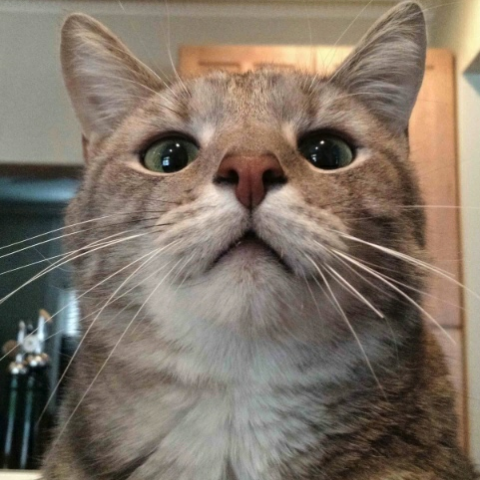

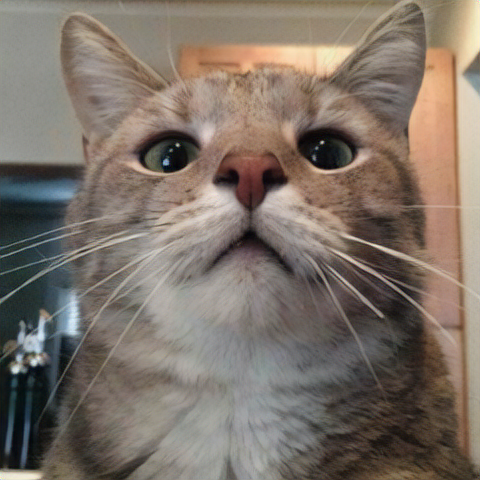

In [0]:
print("Loading content from", content_path)
gilbert_img = load_and_preprocess_image(content_path, size=480)[None,...] # Load with batch dim
plot_image(gilbert_img[0])
plot_image(decoder(encoder(gilbert_img), clip=True)[0])

In [0]:
!wget -c https://www.vangoghgallery.com/img/starry_night_full.jpg
style_img = load_and_preprocess_image('starry_night_full.jpg', 512)[None, ...]

--2019-07-29 21:41:53--  https://www.vangoghgallery.com/img/starry_night_full.jpg
Resolving www.vangoghgallery.com (www.vangoghgallery.com)... 23.99.10.12
Connecting to www.vangoghgallery.com (www.vangoghgallery.com)|23.99.10.12|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
!wget -c https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1920px-Tsunami_by_hokusai_19th_century.jpg
style_img = load_and_preprocess_image('1920px-Tsunami_by_hokusai_19th_century.jpg', 256)[None, ...]

--2019-07-29 21:41:54--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1920px-Tsunami_by_hokusai_19th_century.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Loading style from wikiart_samples/jackson-pollock_the-deep-1953.jpg


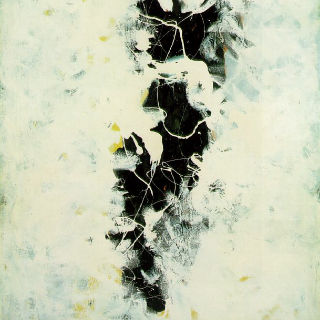

In [0]:
style_path = random.choice(style_image_paths)
print("Loading style from", style_path)
style_img = load_and_preprocess_image(style_path, size=320)[None,...] # Load with batch dim
plot_image(style_img[0])

### Stylize test

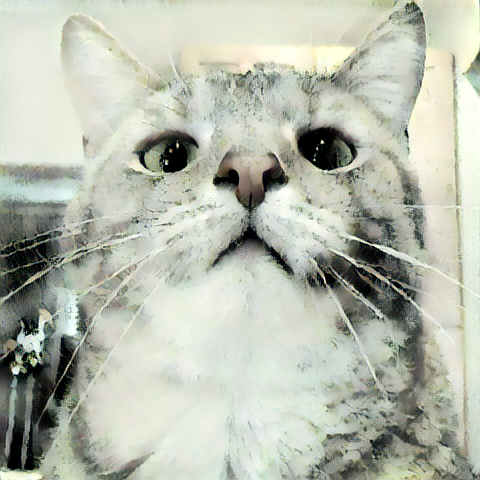

CPU times: user 3.97 s, sys: 441 ms, total: 4.41 s
Wall time: 4.22 s


In [0]:
%%time

content_img = gilbert_img
stylized = stylize(encoder, decoder, 
                   content_img, style_img,
#                    style_feats=style_feats_dict, 
                   transform=wct_tf, 
                   alpha=.85,
                   tiers=[5,4,3],
                   swap5=False, ss_alpha=.6, ss_patch_size=3, ss_stride=1)

plot_image(stylized)

## Webcam Demo

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def setup_stream():
  js = Javascript('''
    async function setupStream() {
      const div = document.createElement('div');
      video = document.createElement('video');
      video.style.display = 'none';
      stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      div.style.visibility='hidden' 
      video.srcObject = stream;
      await video.play();
      // google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
  }
  ''')
  display(js)
  eval_js('setupStream()')

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      canvas.getContext('2d').drawImage(video, 0, 0, video.videoWidth, video.videoHeight);
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
#   print(data)
  binary = b64decode(data.split(',')[1])
  return binary
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return filename

In [0]:
from PIL import Image
import io
import IPython.display as ipydisplay
import time
import numpy as np

def stylize_webcam(randomize_every, tiers, alpha, transform, 
                   swap5, ss_alpha, ss_patch_size, ss_stride,
                   multilevel, passes):
    setup_stream()
    disp_result = ipydisplay.display('', display_id='stylization')
    disp_text = ipydisplay.display('', display_id='time')

    stylize_fn = stylize_multilevel if multilevel else stylize

    i = -1
    while True:
        i += 1
        try: 
            binary = take_photo()
            content_img = Image.open(io.BytesIO(binary))
            content_img = np.array(content_img)[None, ...].astype('float32') / 255

            if i % randomize_every == 0:
                style_height = content_img.shape[1]
                style_path = random.choice(style_image_paths)
                disp_text.update(f"Loading style from {style_path}")
                try:
                    style_img = load_and_preprocess_image(style_path, size=style_height)[None,...] # Load with batch dim
                except:  # tf.image.random_crop sometimes has issues
                    i -= 1
                    continue
                # style_img=sullivan_img
                style_img_np = style_img.numpy()[0]
                # Pre-calculate the style image decoder features
                style_feats_dict = extract_style_feats(encoder, decoder, style_img, tiers)
            
            s = time.time()
            result = content_img
            for _ in range(passes):
                result = stylize_fn(encoder, decoder,
                            result, 
                            # style_img,
                            style_feats=style_feats_dict, 
                            transform=transform, 
                            tiers=tiers,
                            alpha=alpha,
                            swap5=swap5, ss_alpha=ss_alpha, ss_patch_size=ss_patch_size, ss_stride=ss_stride)
                
            disp_text.update(f"Frame {i} stylized in {time.time() - s}")

            output_img = np.hstack([result[0].numpy(), 
                                    np.zeros([style_height, 3, 3]), 
                                    style_img_np])
            output_img = np.uint8(output_img * 255)
            
            # Convert to jpeg before displaying to speed things up
            # See https://medium.com/@kostal91/displaying-real-time-webcam-stream-in-ipython-at-relatively-high-framerate-8e67428ac522
            f = io.BytesIO()
            Image.fromarray(output_img).save(f, 'jpeg')
            disp_result.update(ipydisplay.Image(data=f.getvalue()))
        #     eval_js('''stream.getVideoTracks()[0].stop();''')
        except Exception as err:
            # Errors will be thrown if the user does not have a webcam or if they do not
            # grant the page permission to access it.
            print(str(err))

In [0]:
#@title Stylization Settings { display-mode: "form" }

#@markdown ⬅ Press ▶️ to start webcam stylization demo

randomize_style_every = 5 #@param {type:"integer"}

tiers = 5,4,3,2 #@param {type:"raw"}
tiers = [int(t) for t in tiers]

alpha = 0.95 #@param {type:"slider", min:0, max:1, step:0.05}

transform = "WCT" #@param ["WCT", "AdaIN"] {allow-input: false}
if transform == 'WCT':
    transform = wct_tf
else:
    transform = adain

style_swap_on5 = False #@param {type:"boolean"}
style_swap_alpha = 0.4 #@param {type:"slider", min:0, max:1, step:0.05}
style_swap_patch_size = 5 #@param {type: "integer"}
style_swap_stride = 1 #@param {type: "integer"}

multi_level_transform = False #@param {type:"boolean"}

passes = 1 #@param {type:"integer"}

stylize_webcam(randomize_every=randomize_style_every, 
               tiers=tiers, 
               alpha=alpha,
               transform=transform,
               swap5=style_swap_on5,
               ss_alpha=style_swap_alpha,
               ss_patch_size=style_swap_patch_size,
               ss_stride=style_swap_stride,
               multilevel=multi_level_transform,
               passes=passes)

### Sullivan demo


In [0]:
!wget -c -O sullivan.jpg https://www.dropbox.com/s/rdzkzye8iihgtim/sullivan.jpg?dl=1
sullivan_img = load_and_preprocess_image('sullivan.jpg', size=480)[None,...] # Load with batch dim
plot_image(sullivan_img[0])
plot_image(decoder(encoder(sullivan_img))[0])


In [0]:

from PIL import Image
import io
import IPython.display as ipydisplay
import time
import numpy as np

setup_stream()
disp = ipydisplay.display('', display_id='artnet')
disp_text = ipydisplay.display('', display_id='time')

# def showarray(a, fmt='jpeg'):
#     f = StringIO()
#     Image.fromarray(a).save(f, fmt)
#     return f
# IPython.display.display(IPython.display.Image(data=f.getvalue()))


i = -1
while True:
  i += 1
  try:
    s = time.time()

    binary = take_photo()
    content_img = Image.open(io.BytesIO(binary))
    content_img = np.array(content_img)[None, ...].astype('float32') / 255

    if i % 5 == 0:
        style_height = content_img.shape[1]
        style_path = random.choice(style_image_paths)
        disp_text.update(f"Loading style from {style_path}")
        try:
            style_img = load_and_preprocess_image(style_path, size=style_height)[None,...] # Load with batch dim
        except:  # tf.image.random_crop sometimes has issues
            i -= 1
            continue
        style_img=sullivan_img
        style_img_np = style_img.numpy()[0]
        # disp_style.update(Image.fromarray((style_img[0].numpy() * 255).astype('uint8')))
        # Pre-calculate the style image decoder features
        style_feats_dict = extract_style_feats(encoder, decoder, style_img)
    
    s = time.time()
    stylized = stylize(encoder, decoder, 
                   content_img, 
#                    style_img,
                   style_feats=style_feats_dict, 
                   passes=1, 
                   transform=wct_tf, 
                   tiers=[5,4,3],
                   alpha=0.8,
                   swap5=True, ss_alpha=0.8, ss_patch_size=3, ss_stride=1)
    disp_text.update(f"Frame {i} stylized in {time.time() - s}")

    # stylized = (stylized[0].numpy() * 255).astype('uint8')
  
    output_img = np.hstack([stylized[0].numpy(), 
                                     np.zeros([style_height, 3, 3]), 
                                     style_img_np])
    output_img = np.uint8(output_img * 255)
    
    # Convert to jpeg before displaying to speed things up
    # See https://medium.com/@kostal91/displaying-real-time-webcam-stream-in-ipython-at-relatively-high-framerate-8e67428ac522
    f = io.BytesIO()
    Image.fromarray(output_img).save(f, 'jpeg')

    disp.update(ipydisplay.Image(data=f.getvalue()))
#     eval_js('''stream.getVideoTracks()[0].stop();''')
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))